<a href="https://colab.research.google.com/github/BeckhamB/AIClassification/blob/main/Grad_CAM_Activation_Map.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Session 4 - Class Activation Maps (SmoothGradCAM++)

Another method that you can use to understand a bit more about the inner working of your network is Class Activation Maps (CAM).  In this example we'll use a recent version of that called [SmoothGradCAM++](https://arxiv.org/abs/1908.01224).  The [Github repo](https://github.com/yiskw713/SmoothGradCAMplusplus) for the project also includes code for earlier methods such as [CAM](http://cnnlocalization.csail.mit.edu/Zhou_Learning_Deep_Features_CVPR_2016_paper.pdf), [GradCAM](https://arxiv.org/abs/1610.02391) and [GradCAM++](https://arxiv.org/pdf/1710.11063.pdf).

In [41]:
!git clone https://github.com/yiskw713/SmoothGradCAMplusplus.git

fatal: destination path 'SmoothGradCAMplusplus' already exists and is not an empty directory.


In [42]:
%cd /content/SmoothGradCAMplusplus/

/content/SmoothGradCAMplusplus


In [43]:
import cam

In [44]:
%matplotlib inline

import numpy as np
import skimage.transform
import torch
import torch.nn as nn
import torch.nn. functional as F

from PIL import Image
from matplotlib.pyplot import imshow
from torchvision import models, transforms
from torchvision.utils import save_image

from cam import CAM, GradCAM, GradCAMpp, SmoothGradCAMpp
from utils.visualize import visualize, reverse_normalize
from utils.imagenet_labels import label2idx, idx2label

In [45]:
# mount google drive
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [46]:
# unzip dataset folder 
!unzip '/content/gdrive/MyDrive/arctic_dataset.zip' > /dev/null

replace arctic_dataset/bear/_113530377_bears_kt-miller.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: N


In [47]:
pip install split-folders[full]

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [48]:
import splitfolders

splitfolders.ratio("arctic_dataset", output="split_arctic_dataset",
                   seed=1337, ratio=(.7, .15, .15), group_prefix=None, move=False)

Copying files: 642 files [00:00, 3128.18 files/s]


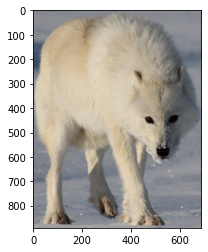

In [49]:
image = Image.open('/content/SmoothGradCAMplusplus/split_arctic_dataset/train/wolf/greenland-polar-wolf-daneborg_morten-petersen.jpg')
imshow(image)

In [50]:
# preprocessing. mean and std from ImageNet
normalize = transforms.Normalize(
   mean=[0.485, 0.456, 0.406],
   std=[0.229, 0.224, 0.225]
)

preprocess = transforms.Compose([
    transforms.ToTensor(),
    normalize
])

In [51]:
# convert image to tensor
tensor = preprocess(image)

# reshape 4D tensor (N, C, H, W)
tensor = tensor.unsqueeze(0)

In [52]:
# Load previously trained model

# create a new model with ResNet18 architecture
myModel = models.resnet50(pretrained=True)
# get the number of inputs for the final layer (fc) of the network
num_ftrs = myModel.fc.in_features
# replace the final layer so that the output is five classes
myModel.fc = nn.Linear(num_ftrs, 5)
# load previously trained model
myModel.load_state_dict(torch.load('/content/gdrive/MyDrive/resnet18_model_fine_tune_aug.pt'))

myModel.eval()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [53]:
# the target layer you want to visualize
target_layer = myModel.layer4[1].conv2

# wrapper for class activation mapping. Choose one of the following.
#wrapped_model = CAM(myModel, target_layer)
wrapped_model = GradCAM(myModel, target_layer)
#wrapped_model = GradCAMpp(myModel, target_layer)
#wrapped_model = SmoothGradCAMpp(myModel, target_layer, n_samples=25, stdev_spread=0.15)

In [54]:
cam, idx = wrapped_model(tensor)

predicted class ids 1	 probability 0.41302943229675293


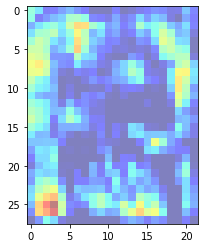

In [55]:
# visualize only cam
imshow(cam.squeeze().numpy(), alpha=0.5, cmap='jet')

In [56]:
# reverse normalization for display
img = reverse_normalize(tensor)

In [57]:
heatmap = visualize(img, cam)

In [58]:
# save image
# save_image(heatmap, './sample/{}_cam.png'.format(idx2label[idx]).replace(" ", "_").replace(",", ""))
# save_image(heatmap, './sample/{}_gradcam.png'.format(idx2label[idx]).replace(" ", "_").replace(",", ""))
# save_image(heatmap, './sample/{}_gradcampp.png'.format(idx2label[idx]).replace(" ", "_").replace(",", ""))
# save_image(heatmap, './sample/{}_smoothgradcampp.png'.format(idx2label[idx]).replace(" ", "_").replace(",", ""))
save_image(heatmap, './sample/smoothgradcampp.png')

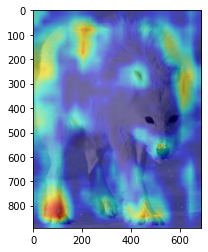

In [59]:
# or visualize on Jupyter
hm = (heatmap.squeeze().numpy().transpose(1, 2, 0))
imshow(hm)